**3. Entrenamiento y test de modelos**

In [1]:
# Instalación de librerías

!pip install pandas scikit-learn

In [2]:
# Importaciones y carga del dataset

import pandas as pd
import gzip
import urllib.request
import json
import os
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import re
import numpy as np

url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz"
ruta_local = "reviews_Books_5.json.gz"
if not os.path.exists(ruta_local):
    print("Descargando dataset...")
    urllib.request.urlretrieve(url, ruta_local)
def cargar_reviews_amazon(path, n_muestras=20000):
    data = []
    with gzip.open(path, 'rt') as f:
        for i, line in enumerate(f):
            data.append(json.loads(line))
            if i+1 >= n_muestras:
                break
    return pd.DataFrame(data)
df = cargar_reviews_amazon(ruta_local, n_muestras=20000)

def etiqueta_sentimiento(star):
    if star >= 4:
        return 'Positiva'
    elif star <= 2:
        return 'Negativa'
    else:
        return 'Neutral'
df['sentimiento'] = df['overall'].apply(etiqueta_sentimiento)

def preprocesar_texto(texto):
    texto = str(texto).lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation + '0123456789'))
    tokens = re.findall(r'\b\w+\b', texto)
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 1]
    return ' '.join(tokens)
df['reviewText_proc'] = df['reviewText'].astype(str).apply(preprocesar_texto)

In [3]:
# Solo positivas/negativas

df_binario = df[df['sentimiento'].isin(['Positiva', 'Negativa'])].copy()
df_binario['sentimiento_bin'] = (df_binario['sentimiento'] == 'Positiva').astype(int)

X = df_binario['reviewText_proc'].values
y = df_binario['sentimiento_bin'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = CountVectorizer(min_df=5, max_df=0.8)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

=== Regresión Logística ===
              precision    recall  f1-score   support

           0     0.6205    0.6877    0.6523       397
           1     0.9606    0.9477    0.9541      3193

    accuracy                         0.9189      3590
   macro avg     0.7905    0.8177    0.8032      3590
weighted avg     0.9230    0.9189    0.9207      3590

=== Naive Bayes ===
              precision    recall  f1-score   support

           0     0.5767    0.7103    0.6366       397
           1     0.9629    0.9352    0.9488      3193

    accuracy                         0.9103      3590
   macro avg     0.7698    0.8227    0.7927      3590
weighted avg     0.9202    0.9103    0.9143      3590



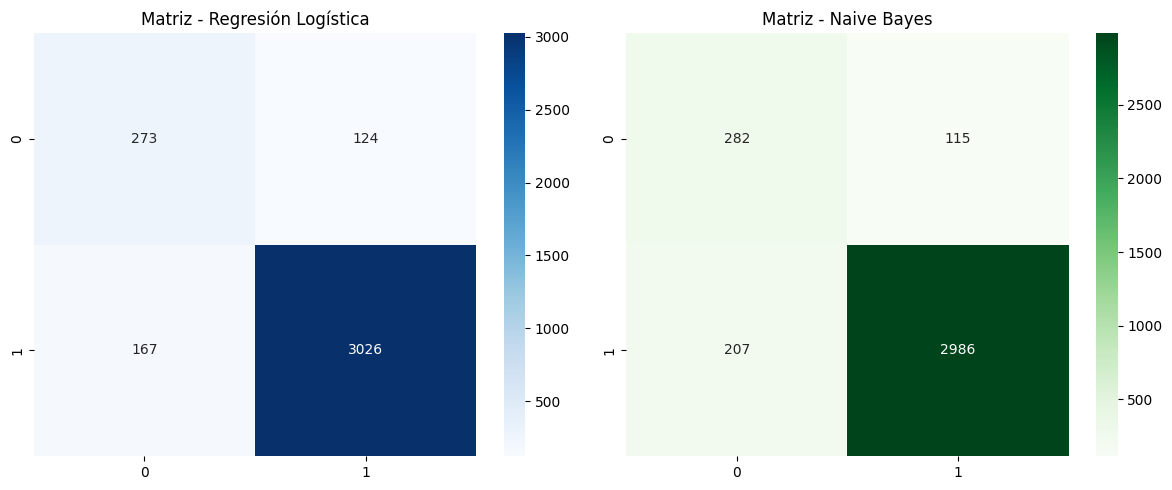

In [5]:
# Modelos y evaluación

modelo_lr = LogisticRegression(max_iter=200, class_weight='balanced', random_state=42)
modelo_lr.fit(X_train_bow, y_train)
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train_bow, y_train)

y_pred_lr = modelo_lr.predict(X_test_bow)
y_pred_nb = modelo_nb.predict(X_test_bow)

print("=== Regresión Logística ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb, digits=4))

from matplotlib import pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Matriz - Regresión Logística")
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt="d", cmap="Greens", ax=axs[1])
axs[1].set_title("Matriz - Naive Bayes")
plt.tight_layout()
plt.show()